In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "peppers",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2475 files belonging to 2 classes.


In [3]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [4]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


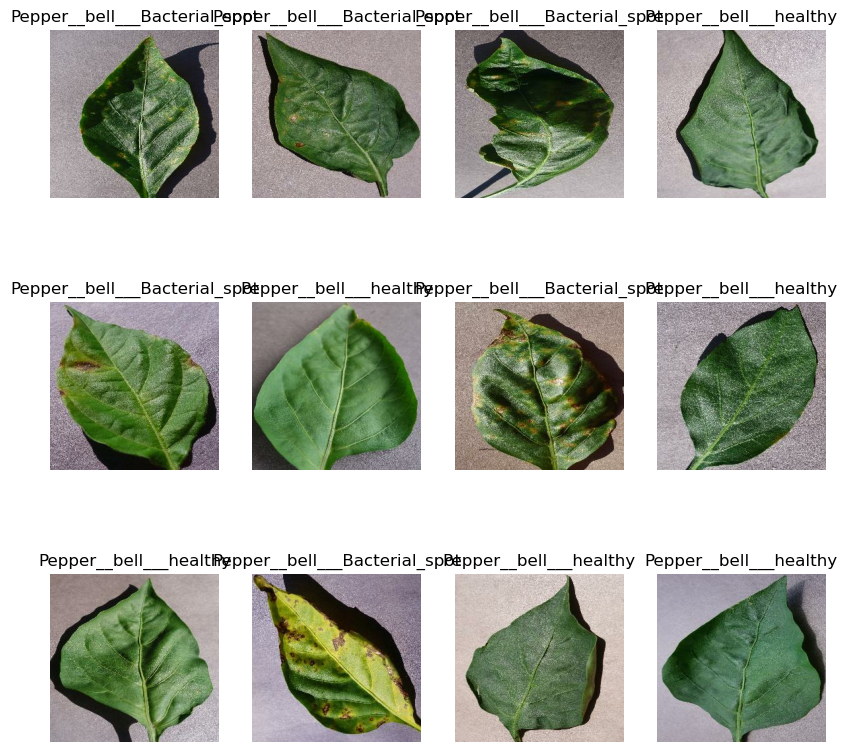

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
train_size = 0.8
len(dataset)*train_size

62.400000000000006

In [7]:
train_ds = dataset.take(54)
len(train_ds)


54

In [8]:
test_ds = dataset.skip(54)
len(test_ds)

24

In [9]:
val_size=0.1
len(dataset)*val_size

7.800000000000001

In [10]:
val_ds = test_ds.take(6)
len(val_ds)


6

In [11]:

test_ds = test_ds.skip(6)
len(test_ds)

18

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

In [19]:
#vgg16

In [20]:
# model = models.Sequential([
#     resize_and_rescale,
#     layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape,padding='same'),
#     layers.Conv2D(64, kernel_size = (3,3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2),strides=(2,2)),
#     layers.Conv2D(128, kernel_size = (3,3), activation='relu', padding='same'),
#     layers.Conv2D(128,  kernel_size = (3,3), activation='relu',padding='same'),
#     layers.MaxPooling2D((2, 2),strides=(2,2)),
#     layers.Conv2D(256,  kernel_size = (3,3), activation='relu',padding='same'),
#     layers.Conv2D(256,  kernel_size = (3,3), activation='relu',padding='same'),
#     layers.Conv2D(256,  kernel_size = (3,3), activation='relu',padding='same'),
#     layers.MaxPooling2D((2, 2),strides=(2,2)),
#     layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
#     layers.MaxPooling2D((2, 2),strides=(2,2)),
#     layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu',padding='same'),
#     layers.MaxPooling2D((2, 2),strides=(2,2)),
#     layers.Conv2D(64, (3, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])
# model.build(input_shape=input_shape)


In [21]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
# model = Sequential()
# model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(MaxPooling2D(pool_(2, 2)),
#     model.add(layers.Flatten())
#    model.add layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
    
)

Epoch 1/25


62/62 [==============================] - 60s 929ms/step - loss: 0.6180 - accuracy: 0.6424 - val_loss: 0.4006 - val_accuracy: 0.9062
Epoch 2/25
62/62 [==============================] - 53s 855ms/step - loss: 0.2879 - accuracy: 0.8945 - val_loss: 0.3848 - val_accuracy: 0.9241
Epoch 3/25
62/62 [==============================] - 53s 856ms/step - loss: 0.1744 - accuracy: 0.9435 - val_loss: 0.7221 - val_accuracy: 0.9554
Epoch 4/25
62/62 [==============================] - 54s 864ms/step - loss: 0.1711 - accuracy: 0.9572 - val_loss: 0.1159 - val_accuracy: 0.9732
Epoch 5/25
62/62 [==============================] - 53s 859ms/step - loss: 0.0864 - accuracy: 0.9801 - val_loss: 0.1178 - val_accuracy: 0.9955
Epoch 6/25
62/62 [==============================] - 53s 858ms/step - loss: 0.0538 - accuracy: 0.9868 - val_loss: 0.3146 - val_accuracy: 0.9955
Epoch 7/25
62/62 [==============================] - 54s 869ms/step - loss: 0.0975 - accuracy: 0.9771 - val_loss: 0.1068 - val_accuracy: 0.97

In [26]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 3s 194ms/step - loss: 0.0227 - accuracy: 0.9931


In [27]:
print((history))
print(history.params)
print(history.history.keys())


type(history.history['loss'])

print(len(history.history['loss']))

print(history.history['loss'][:5] )#

{'verbose': 1, 'epochs': 25, 'steps': 62}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
25
[0.6180347204208374, 0.2879355549812317, 0.17442886531352997, 0.17105510830879211, 0.08638288080692291]


In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

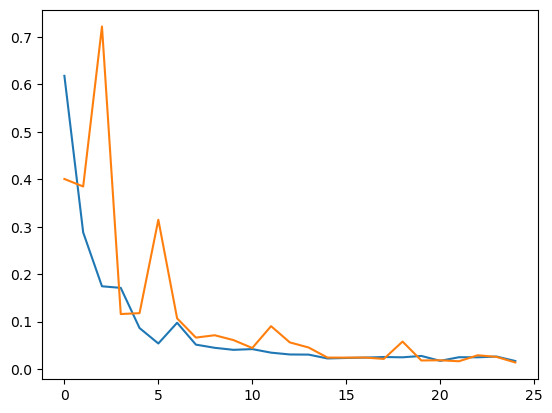

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


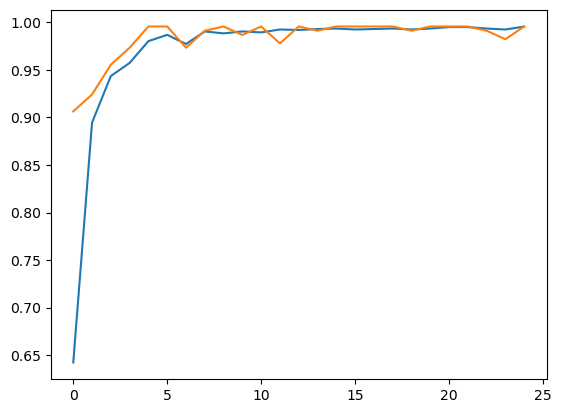

In [30]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])

In [31]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


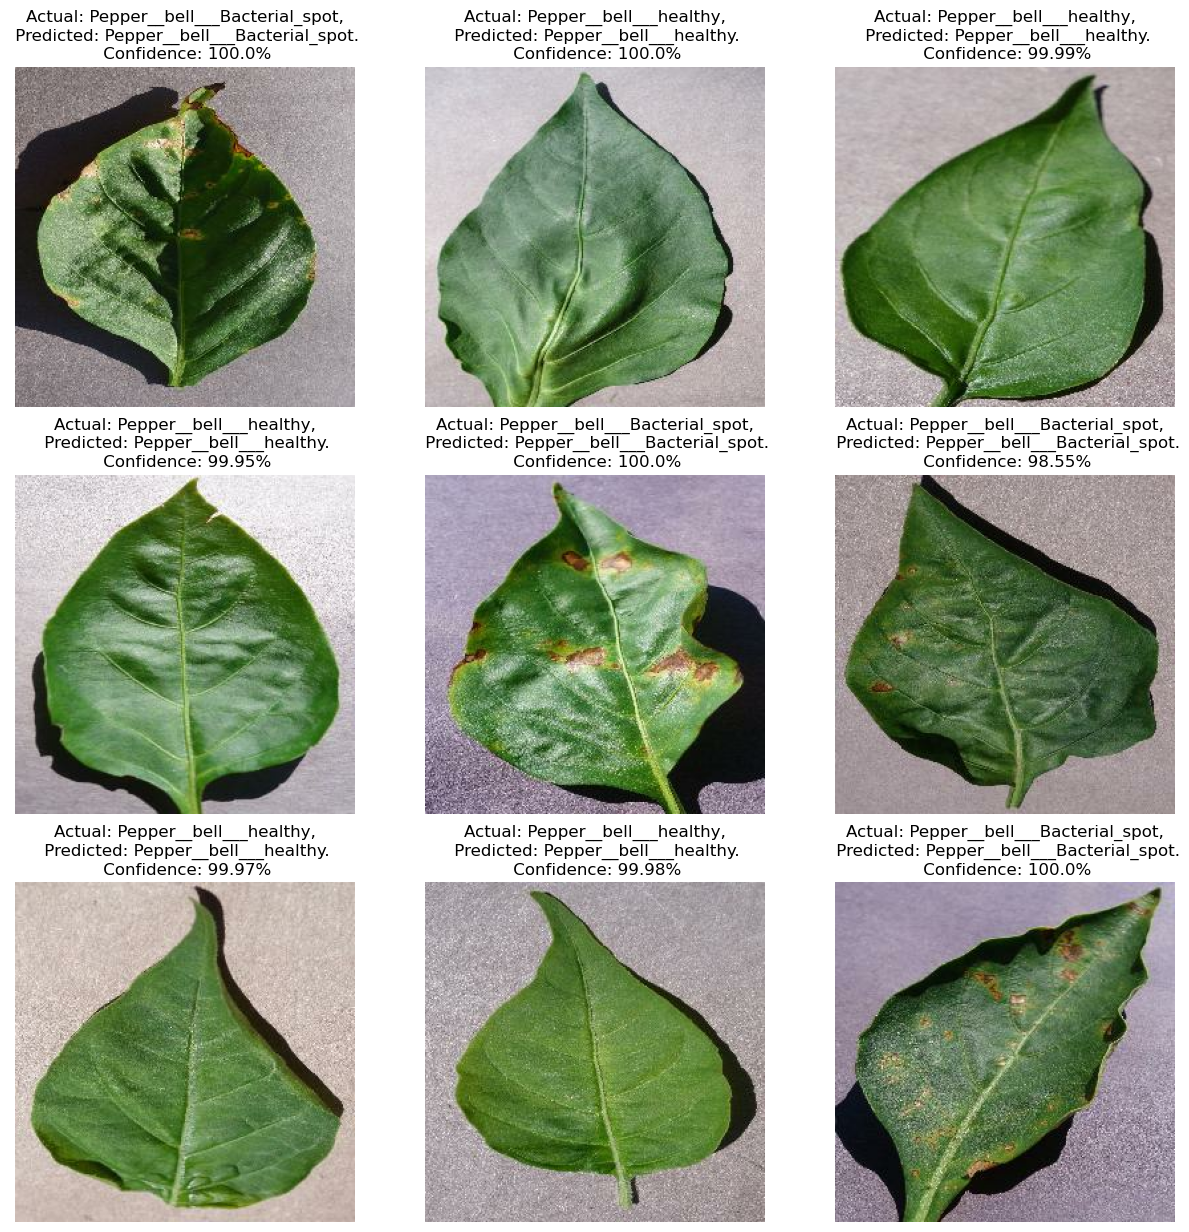

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [33]:
model.save("peppers.h5")

C:\Users\vasek\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

open("model.tflite",'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\vasek\AppData\Local\Temp\tmpb8f8vpek\assets


INFO:tensorflow:Assets written to: C:\Users\vasek\AppData\Local\Temp\tmpb8f8vpek\assets


741564

In [35]:
model.save("peppers2.h5")

C:\Users\vasek\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
